In [1]:
# Install the openpyxl library (if not already installed)
!pip install -q openpyxl
!pip install -q xlrd
!pip install -q sdv
# Import pandas
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.15.0 requires botocore<1.35.17,>=1.35.16, but you have botocore 1.35.63 which is incompatible.
conda 24.7.1 requires packaging>=23.0, but you have packaging 21.3 which is incompatible.
jupyterlab 4.2.5 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
jupyterlab-lsp 5.1.0 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
libpysal 4.9.2 requires packaging>=22, but you have packaging 21.3 which is incompatible.
libpysal 4.9.2 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
virtualenv 20.21.0 requires platformdirs<4,>=2.4, but you have platformdirs 4.3.6 which is incompatible.


# Trigger Download

In [2]:
from IPython.display import FileLink, display, HTML, Javascript

def trigger_download(filename, my_id=0):
    # Create the FileLink object
    file_link = FileLink(filename)

    # Get the path of the file
    file_path = file_link.path

    # Create the HTML link
    html = f'<a id="download_link_{file_path}_{my_id}" href="{file_path}" download>{file_path}</a>'

    # Display the HTML link
    display(HTML(html))

    # Create and run the JavaScript to automatically click the link
    js_code = f'''
    var link = document.getElementById('download_link_{file_path}_{my_id}');
    link.click();
    '''
    display(Javascript(js_code))




# Save CheckPoint

In [3]:
import torch

def save_checkpoint(model, optimizer, lr_scheduler, filename='checkpoint.pth'):
    """
    Saves the model, optimizer, and learning rate scheduler states to a file.

    Args:
        model (torch.nn.Module): The model to save.
        optimizer (torch.optim.Optimizer): The optimizer whose state should be saved.
        lr_scheduler (torch.optim.lr_scheduler._LRScheduler): The learning rate scheduler.
        filename (str): The path to the file where the checkpoint will be saved.
    """
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': lr_scheduler.state_dict(),
    }, filename)


# Load CheckPoint

In [4]:
import torch

def load_checkpoint(model, optimizer, lr_scheduler, filename='checkpoint.pth'):
    """
    Loads the model, optimizer, and learning rate scheduler states from a file.

    Args:
        model (torch.nn.Module): The model to load the state into.
        optimizer (torch.optim.Optimizer): The optimizer to load the state into.
        lr_scheduler (torch.optim.lr_scheduler._LRScheduler): The learning rate scheduler to load the state into.
        filename (str): The path to the file where the checkpoint is saved.
    """
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    lr_scheduler.load_state_dict(checkpoint['scheduler_state_dict'])


# Read original data

In [5]:
# original_ground_truth=pd.read_csv("/kaggle/input/gldas-fixed-data/original_ground_truth.csv",low_memory=False)

In [6]:
# import matplotlib.pyplot as plt
# import numpy as np
# plt.hist(np.array(original_ground_truth[['Min-gwl_2005']].values,dtype='float32'))

In [7]:
# original_ground_truth.shape

In [8]:
pseudo_ground_truth=pd.read_csv('/kaggle/input/gldas-fixed-data/pseudo_ground_truth.csv')

In [9]:
# import matplotlib.pyplot as plt
# import numpy as np
# plt.hist(np.array(pseudo_ground_truth[['Max-gwl_2005']].values,dtype='float32'))

# Keeping only threshold pseudo data

In [10]:
# import numpy as np
# import pandas as pd
# from geopy.distance import geodesic
# from scipy.spatial import KDTree

# # Function to calculate geodesic distance between two points (in km)
# def haversine_distance(lat1, lon1, lat2, lon2):
#     R = 6371.0  # Radius of the Earth in km
#     phi1, phi2 = np.radians(lat1), np.radians(lat2)
#     delta_phi = np.radians(lat2 - lat1)
#     delta_lambda = np.radians(lon2 - lon1)
    
#     a = np.sin(delta_phi / 2) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2) ** 2
#     c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
#     return R * c  # in kilometers

# def filter_by_distance_kdtree(original_df, psuedo_df, distance_km=2):
#     # Convert the latitude and longitude to radians for KDTree
#     original_coords = np.radians(original_df[['POINT_Y', 'POINT_X']].values)  # (Lat, Lng)
#     psuedo_coords = np.radians(psuedo_df[['POINT_Y', 'POINT_X']].values)      # (Lat, Lng)
    
#     # Create a KDTree for the original coordinates
#     tree = KDTree(original_coords)
    
#     # Query the KDTree for all psuedo points to find points within the radius
#     # The radius here is converted to radians as well (distance_km / Earth's radius in km)
#     radius = distance_km / 6371.0  # Earth's radius in km
#     far_enough = np.full(len(psuedo_coords), True)  # Initialize all as True
    
#     for i, psuedo_point in enumerate(psuedo_coords):
#         # Query the tree to find if there are any points within the given radius
#         idx = tree.query_ball_point(psuedo_point, radius)
#         if idx:  # If there are any nearby points, mark this point as False
#             far_enough[i] = False
    
#     # Filter the psuedo dataframe for points that are far enough from all original points
#     filtered_psuedo_df = psuedo_df[far_enough]
    
#     # Return the original dataframe and the filtered pseudo dataframe
#     return original_df, filtered_psuedo_df

# # Usage example
# original_filtered_df, psuedo_filtered_df = filter_by_distance_kdtree(original_ground_truth, pseudo_ground_truth,1)


In [11]:
# filtered=pd.concat([original_filtered_df, psuedo_filtered_df])
# filtered.shape

In [12]:
# original_filtered_df

In [13]:
filtered=pd.read_csv('/kaggle/input/original-and-pseudo-gwl-data/original_and_pseudo_gwl (2).csv').drop(columns=['recharge'])

# Splitting data yearwise 

## Funxtion for splitting the data into year wise

In [14]:
import pandas as pd

def reshape_by_year(df):
    """
    Reshape the input dataframe so that each row corresponds to a specific year with 
    NDVI, NDWI, Min-GWL, and Max-GWL values for that year.
    
    Parameters:
    df (pd.DataFrame): Original dataframe containing the yearly data in separate columns.
    
    Returns:
    pd.DataFrame: Reshaped dataframe with one row per year containing NDVI, NDWI, Min-GWL, and Max-GWL.
    """
    # Step 1: Create a list of years
    years = list(range(2003, 2023))  # Assuming the years range from 2001 to 2023

    # Step 2: Prepare a dataframe for each year with NDWI, NDVI, and Min/Max GWL
    reshaped_df = pd.DataFrame()
#     print(df.shape)
    for year in years:
        # Filter the columns related to the current year
        year_columns = [f'NDVI{year}', f'NDWI{year}', f'Min-gwl_{year}', f'Max-gwl_{year}']
        
        # Create a temporary dataframe for the current year
        year_df = df[[ 'POINT_X', 'POINT_Y', 
                       'TWI', 'TRI', 'Sy', 'STI', 'SPI', 'Slope', 
                      'Profile_curvature', 'Plan_curvature', 'lithology', 'lithology_clay_thickness', 
                      'Distance_from_stream', 'elevation', 'drainage_density', 'Curvature', 
                      'Aspect', 'GLDAS_SerialID']].copy()

        # Add the NDVI, NDWI, and GWL columns for the current year
        year_df['NDVI'] = df[f'NDVI{year}']
        year_df['NDWI'] = df[f'NDWI{year}']
        year_df['Min_GWL'] = df[f'Min-gwl_{year}']
        year_df['Max_GWL'] = df[f'Max-gwl_{year}']
        
        # Add the year as a column
        year_df['Year'] = year
#         print(reshaped_df.shape)
        # Append the temporary dataframe to the final dataframe
        reshaped_df = pd.concat([reshaped_df, year_df], ignore_index=True)

    # Step 3: Return the reshaped dataframe
    return reshaped_df




In [15]:
# melted

# Reading GLDAS

In [16]:
gldas_ndvi=pd.read_excel('/kaggle/input/gldas-fixed-data/GLDAS1_Gridwise_ndvi_ndwi_24Sept2024.xls')
gldas_hgf=pd.read_excel('/kaggle/input/gldas-fixed-data/GLDAS1_Gridwise_14HgfValue_flood_clay_and GWL 18Sept2024.xls').rename(columns={'X':'POINT_X','Y':'POINT_Y'})

In [17]:
# gldas_ndvi.columns

In [18]:
gldas_pre=gldas_hgf.merge(gldas_ndvi,on=['SerialID'],how='inner').drop(columns=['drainage density_corrected','ORIG_FID','ID']).rename(columns={'SerialID':'GLDAS_SerialID'})

In [19]:
for i in gldas_pre.columns[~gldas_pre.columns.str.contains('GWS')&~gldas_pre.columns.str.contains('nd')]:
    print(i)

POINT_X
POINT_Y
GLDAS_SerialID
Curvature
Slope_o_
Profile_curvature
Plan_curvature
Distance_from_stream
Aspect
drainage_density_MAJORITY
Elevation_MAJORITY
lithology_MAJORITY
SPI_MAJORITY
STI_MAJORITY
Sy_MAJORITY
TRI_MAJORITY
TWI_MAJORITY
lithology_clay_thickness_MAJORITY


In [20]:

def reshape_by_year(df):
    """
    Reshape the input dataframe so that each row corresponds to a specific year with
    NDVI, NDWI, Min-GWL, and Max-GWL values for that year.

    Parameters:
    df (pd.DataFrame): Original dataframe containing the yearly data in separate columns.

    Returns:
    pd.DataFrame: Reshaped dataframe with one row per year containing NDVI, NDWI, Min-GWL, and Max-GWL.
    """
    # Step 1: Create a list of years
    years = list(range(2003, 2023))  # Assuming the years range from 2001 to 2023

    # Step 2: Prepare a dataframe for each year with NDWI, NDVI, and Min/Max GWL
    reshaped_df = pd.DataFrame()
#     print(df.shape)
    for year in years:
        # Filter the columns related to the current year
        year_columns = [f'ndvi{year}', f'ndwi{year}', f'Min-gwl_{year}', f'Max-gwl_{year}']
        
        # Create a temporary dataframe for the current year
        year_df = df[gldas_pre.columns[~gldas_pre.columns.str.contains('GWS')&~gldas_pre.columns.str.contains('nd')]
                    ].copy()

        # Add the NDVI, NDWI, and GWL columns for the current year
        year_df['NDVI'] = df[f'ndvi{year}']
        year_df['NDWI'] = df[f'ndwi{year}']
        year_df['Min_GWS'] = df[f'Min_GWS_{year}']
        year_df['Max_GWS'] = df[f'Max_GWS_{year}']

        # Add the year as a column
        year_df['Year'] = year
#         print(reshaped_df.shape)
        # Append the temporary dataframe to the final dataframe
        reshaped_df = pd.concat([reshaped_df, year_df], ignore_index=True)

    # Step 3: Return the reshaped dataframe
    return reshaped_df

In [21]:
gldas=reshape_by_year(gldas_pre)

In [22]:
gldas

,POINT_X,POINT_Y,GLDAS_SerialID,Curvature,Slope_o_,Profile_curvature,Plan_curvature,Distance_from_stream,Aspect,drainage_density_MAJORITY,...,STI_MAJORITY,Sy_MAJORITY,TRI_MAJORITY,TWI_MAJORITY,lithology_clay_thickness_MAJORITY,NDVI,NDWI,Min_GWS,Max_GWS,Year
0,88.625,26.375,2,0.000000,0.999202,0.027039,0.027039,7614.683,45.00000,3,...,3,14,28,10,0,0.124415,-0.133074,700.587097,1023.652039,2003
1,88.375,26.125,6,0.000000,0.744795,0.000000,0.000000,6357.311,341.56510,5,...,3,14,26,8,1,0.118439,-0.128377,664.832825,1023.167297,2003
2,88.625,26.125,7,0.108158,2.025331,0.043263,0.151421,2502.259,324.46230,9,...,2,13,25,7,1,0.144492,-0.150702,682.630127,1023.635071,2003
3,88.875,26.125,8,0.000000,0.333097,0.000000,0.000000,1590.283,45.00000,4,...,3,12,20,8,2,0.118325,-0.126231,630.430298,967.507568,2003
4,89.125,26.125,9,-0.108158,0.942067,0.108158,0.000000,2376.068,270.00000,8,...,3,12,20,9,2,0.119673,-0.133754,648.113281,933.255188,2003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,92.125,21.375,229,-0.108158,0.744795,0.108158,0.000000,5930.599,251.56500,3,...,4,4,12,7,21,0.381805,-0.349149,666.473084,1127.625366,2022
3996,92.625,21.375,231,-0.432630,10.543780,0.517402,0.084772,2340.000,83.65981,1,...,4,4,0,7,22,0.393084,-0.355641,597.517334,1090.277466,2022
3997,92.125,21.125,232,-0.108158,1.941553,0.108158,0.000000,18692.340,284.03630,0,...,5,4,0,8,22,0.392133,-0.357745,565.185547,1044.723877,2022
3998,89.625,25.625,235,-0.108158,1.200837,0.108158,0.000000,6977.048,281.30990,13,...,2,11,14,8,4,0.215177,-0.198773,637.356445,1021.209534,2022


In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm, LinearSegmentedColormap

def plot_column_as_points(data,column_values,column_name):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))

    # Extract values for the current column
    longitudes=data.POINT_X
    latitudes=data.POINT_Y

    # Define your ranges and corresponding colors
    boundaries = [0, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1550, 1600, 1700, 1800]
    cmap_colors = [
        'blue',         # below 0
        '#a8e1e0',      # < 5.3 (light blue)
        '#66c18a',      # 5.3 to < 7.6 (light green)
        '#3b7a3d',      # 7.6 to < 9.8 (dark green)
        '#f3d5a4',      # 9.8 to < 11.3 (light purple)
        '#b299ca',      # 11.3 to < 15 (purple)
        '#e4a6a3',      # 15 to < 20.5 (light red)
        '#d35d60',      # 20.5 to < 26 (red)
        '#a0322e',      # 26 to < 35.5 (dark red)
        '#330e0f',      # 35.5 to < 58 (dark gray)
        '#4f4d4d',      # 58 to < 60 (gray)
        '#7d7b7b',      # 60 to < 70 (light gray)
        '#a9a8a8',      # 70 to < 80 (lighter gray)
        '#c2c0c0',      # 80 to < 90 (lightest gray)
        '#dbdbdb',      # 90 to < 100 (almost white)
        'black'         # 100+ (black)
    ]

    # Create a custom colormap using LinearSegmentedColormap
    cmap = LinearSegmentedColormap.from_list("custom_cmap", cmap_colors)
    norm = BoundaryNorm(boundaries, cmap.N)

    # Scatter plot with discrete color mapping
    sc = ax.scatter(longitudes, latitudes, c=column_values, cmap=cmap, norm=norm, s=100, edgecolor='None')

    # Add a color bar
    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label(f'{column_name} (m)')

    # Add title and labels
    ax.set_title(f'{column_name} GWL Points ')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    # Save the plot to file
    plt.savefig(f'{column_name}.png', dpi=300)
    print(column_name)
    plt.show()

# Example Usage
# Assuming data is a DataFrame containing column_name values and 'longitudes', 'latitudes' as separate arrays
# plot_column_as_points('GWL_Column', data, longitudes, latitudes)


In [24]:
# !rm -r *

In [25]:
# # cur_data=original_with_no_nans
# cur_data=gldas

# for mode in gldas.columns[gldas.columns.str.contains('GWS')].tolist():
#     A=cur_data
# #     B=cur_data[cur_data.Year==year-1].sort_values(by=['POINT_X','POINT_Y'])
#     x=A[mode].values.reshape(-1)
# #         y=B['min_gwl'].values.reshape(-1)
#     print(A.shape,x.shape)
#     year=mode[8:]
# #     print(year)
#     if year[0]=="_":
#         year="0"+year[1]
# #     print(year)
#     plot_column_as_points(A,x,f'GLDAS {mode[:7]} for the year {year}')

In [26]:
# !zip GLDAS.zip *GLDAS*

In [27]:
# trigger_download('GLDAS.zip')

In [28]:
import pandas as pd

# Assuming 'gldas' is your dataframe
# Check for 'ND' in each column and create a list of columns containing 'ND'

columns_with_nd = gldas.columns[gldas.columns.str.contains('ND')]

print("Columns containing 'ND':", columns_with_nd)


Columns containing 'ND': Index(['NDVI', 'NDWI'], dtype='object')


In [29]:
gldas[columns_with_nd].isnull().any()

NDVI    False
NDWI    False
dtype: bool

In [30]:
# # Step 1: Create a SimpleImputer with the desired strategy
# imputer = KNNImputer(n_neighbors=25, weights="distance")
# temp=imputer.fit_transform(gldas[columns_with_nd])
# gldas.drop(columns=columns_with_nd)
# gldas[columns_with_nd]=temp

In [31]:
# gldas_split = reshape_by_year(gldas)
# gldas_split.head()
# gldas_split.rename(columns={'Min_GWL':'Min_GWS','Max_GWL':'Max_GWS'}
#                       ,inplace=True)

In [32]:
gldas_split=gldas

In [33]:
import pandas as pd

# Assuming reshaped_data is your DataFrame
filtered['GLDAS_SerialID'] = filtered['GLDAS_SerialID'].astype(int)


In [34]:
filtered[['GLDAS_SerialID']].isnull().any()

GLDAS_SerialID    False
dtype: bool

In [35]:
filtered['lithology'] = filtered['lithology'].astype('string')
gldas_split['lithology_MAJORITY'] = gldas_split['lithology_MAJORITY'].astype('string')


In [36]:
gldas_split.to_csv('gldas_data_yearwise.csv')

In [37]:
# trigger_download('gldas_data_yearwise.csv')

In [38]:
data=filtered.merge(gldas_split,on=['GLDAS_SerialID','Year'])

In [39]:
for i in data.columns:
    print(i)

Unnamed: 0
POINT_X_x
POINT_Y_x
GLDAS_SerialID
TWI
TRI
Sy
STI
SPI
Slope
Profile_curvature_x
Plan_curvature_x
lithology
lithology_clay_thickness
Distance_from_stream_x
elevation
drainage_density
Curvature_x
Aspect_x
NDVI_x
NDWI_x
Min_GWL
Year
Max_GWL
POINT_X_y
POINT_Y_y
Curvature_y
Slope_o_
Profile_curvature_y
Plan_curvature_y
Distance_from_stream_y
Aspect_y
drainage_density_MAJORITY
Elevation_MAJORITY
lithology_MAJORITY
SPI_MAJORITY
STI_MAJORITY
Sy_MAJORITY
TRI_MAJORITY
TWI_MAJORITY
lithology_clay_thickness_MAJORITY
NDVI_y
NDWI_y
Min_GWS
Max_GWS


In [40]:
# data['Distance_x']=data['POINT_X_y']-data['POINT_X_x']

In [41]:
# data['Distance_y']=data['POINT_Y_y']-data['POINT_Y_x']

In [42]:
data2=data.drop(columns=['POINT_X_x','POINT_Y_x','POINT_X_y','POINT_Y_y','GLDAS_SerialID','Year'])

In [43]:
# data2.TWI_y=data2.TWI_y.astype('float')

In [44]:
data2.isnull().any()

Unnamed: 0                           False
TWI                                  False
TRI                                  False
Sy                                   False
STI                                  False
SPI                                  False
Slope                                False
Profile_curvature_x                  False
Plan_curvature_x                     False
lithology                            False
lithology_clay_thickness             False
Distance_from_stream_x               False
elevation                            False
drainage_density                     False
Curvature_x                          False
Aspect_x                             False
NDVI_x                               False
NDWI_x                               False
Min_GWL                              False
Max_GWL                              False
Curvature_y                          False
Slope_o_                             False
Profile_curvature_y                  False
Plan_curvat

In [45]:
data2

,Unnamed: 0,TWI,TRI,Sy,STI,SPI,Slope,Profile_curvature_x,Plan_curvature_x,lithology,...,SPI_MAJORITY,STI_MAJORITY,Sy_MAJORITY,TRI_MAJORITY,TWI_MAJORITY,lithology_clay_thickness_MAJORITY,NDVI_y,NDWI_y,Min_GWS,Max_GWS
0,6,0.255545,0.074893,0.173580,0.184533,0.220572,0.051475,0.493018,0.431472,4,...,3,2,3,12,8,19,0.108515,-0.129290,547.630554,990.610352
1,7,0.213646,0.078591,0.635148,0.149744,0.176472,0.083764,0.493018,0.302030,16,...,4,3,2,12,8,13,0.186746,-0.188620,599.266724,1014.424622
2,8,0.329889,0.268481,0.202205,0.360275,0.263276,0.289177,0.631880,0.402571,25,...,3,2,2,9,9,16,0.145139,-0.146902,598.232849,971.328613
3,9,0.291553,0.046225,0.148360,0.303102,0.228972,0.011513,0.493018,0.345178,9,...,3,2,3,12,7,26,0.159937,-0.155903,489.595306,872.133179
4,10,0.246262,0.092990,0.266998,0.415691,0.260741,0.143999,0.568075,0.336548,6,...,3,1,4,5,8,11,0.175389,-0.161469,612.418823,991.001892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
681815,725661,0.404947,0.156650,0.856919,0.240951,0.315590,0.034534,0.440895,0.377538,27,...,4,3,14,28,10,0,0.189946,-0.179747,566.999268,991.587707
681816,725663,0.267126,0.211593,0.849947,0.299017,0.255621,0.036402,0.451320,0.388325,27,...,4,3,14,28,10,0,0.189946,-0.179747,566.999268,991.587707
681817,725664,0.430751,0.121341,0.860967,0.227413,0.332163,0.016281,0.534716,0.345178,27,...,4,3,14,28,10,0,0.189946,-0.179747,566.999268,991.587707
681818,725666,0.454341,0.159815,0.867204,0.197431,0.337291,0.032560,0.534716,0.345178,27,...,4,3,14,28,10,0,0.189946,-0.179747,566.999268,991.587707


In [46]:
data2.isnull().any()

Unnamed: 0                           False
TWI                                  False
TRI                                  False
Sy                                   False
STI                                  False
SPI                                  False
Slope                                False
Profile_curvature_x                  False
Plan_curvature_x                     False
lithology                            False
lithology_clay_thickness             False
Distance_from_stream_x               False
elevation                            False
drainage_density                     False
Curvature_x                          False
Aspect_x                             False
NDVI_x                               False
NDWI_x                               False
Min_GWL                              False
Max_GWL                              False
Curvature_y                          False
Slope_o_                             False
Profile_curvature_y                  False
Plan_curvat

In [47]:
# from sdv.metadata import Metadata

# metadata = Metadata.detect_from_dataframe(
#     data=data2,
# #     table_name='hotel_guests'
# )

# Making X and Y

In [48]:
X=data2.drop(columns=['Min_GWL','Max_GWL'])
y=data2[['Min_GWL','Max_GWL']]

In [49]:
X_numerical=X.drop(columns=['lithology','lithology_MAJORITY','Unnamed: 0'])
X_cat=X[['lithology','lithology_MAJORITY']]

In [50]:
X_numerical.columns

Index(['TWI', 'TRI', 'Sy', 'STI', 'SPI', 'Slope', 'Profile_curvature_x',
       'Plan_curvature_x', 'lithology_clay_thickness',
       'Distance_from_stream_x', 'elevation', 'drainage_density',
       'Curvature_x', 'Aspect_x', 'NDVI_x', 'NDWI_x', 'Curvature_y',
       'Slope_o_', 'Profile_curvature_y', 'Plan_curvature_y',
       'Distance_from_stream_y', 'Aspect_y', 'drainage_density_MAJORITY',
       'Elevation_MAJORITY', 'SPI_MAJORITY', 'STI_MAJORITY', 'Sy_MAJORITY',
       'TRI_MAJORITY', 'TWI_MAJORITY', 'lithology_clay_thickness_MAJORITY',
       'NDVI_y', 'NDWI_y', 'Min_GWS', 'Max_GWS'],
      dtype='object')

In [51]:


# Assume X_continuous is your continuous data with missing values


# Step 3: Normalize the imputed data
scaler = StandardScaler()
X_numerical_scaled = scaler.fit_transform(X_numerical)

# X_continuous_scaled is now imputed and normalized


In [52]:
X_numerical.columns

Index(['TWI', 'TRI', 'Sy', 'STI', 'SPI', 'Slope', 'Profile_curvature_x',
       'Plan_curvature_x', 'lithology_clay_thickness',
       'Distance_from_stream_x', 'elevation', 'drainage_density',
       'Curvature_x', 'Aspect_x', 'NDVI_x', 'NDWI_x', 'Curvature_y',
       'Slope_o_', 'Profile_curvature_y', 'Plan_curvature_y',
       'Distance_from_stream_y', 'Aspect_y', 'drainage_density_MAJORITY',
       'Elevation_MAJORITY', 'SPI_MAJORITY', 'STI_MAJORITY', 'Sy_MAJORITY',
       'TRI_MAJORITY', 'TWI_MAJORITY', 'lithology_clay_thickness_MAJORITY',
       'NDVI_y', 'NDWI_y', 'Min_GWS', 'Max_GWS'],
      dtype='object')

In [53]:
import pandas as pd
X_cat_encoded = pd.get_dummies(X_cat)


In [54]:
import torch
X_final=torch.tensor(np.hstack([X_numerical_scaled,X_cat_encoded]).astype('float32'))
y_final=torch.tensor(y.values.astype('float32'))

In [55]:
X_all=np.hstack([scaler.transform(data[X_numerical.columns]),pd.get_dummies(data[X_cat.columns])])

In [56]:
encoded_columns=X_numerical.columns.tolist()+pd.get_dummies(data[X_cat.columns]).columns.tolist()

In [57]:
X_all=torch.tensor(X_all.astype('float32'))

In [58]:
y_all=torch.tensor(data[y.columns].values.astype('float32'))

In [59]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X_final,y_final,test_size=0.2)

# Upsampling Model

In [60]:
from sklearn.ensemble import RandomForestRegressor

# Create a random forest regressor
upscaling_model = RandomForestRegressor(n_estimators=100, random_state=42,verbose=1)


## Training and evaluating

In [ ]:
from sklearn.metrics import r2_score
upscaling_model.fit(X_train,y_train)
y_pred=upscaling_model.predict(X_test)
# Assuming y_test and y_pred are your true and predicted values respectively
r2 = r2_score(y_test, y_pred)

print(f"R² Score: {r2}")


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed: 20.0min


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from joblib import dump

# Save the model without compression
dump(upscaling_model, 'upscaling_model.joblib')


In [ ]:
dump(scaler, 'scaler_for_high_low.joblib')


In [ ]:
trigger_download('upscaling_model.joblib')

In [ ]:
trigger_download('scaler_for_high_low.joblib')

In [ ]:
print('ok')


## Leave one year out Test

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
from tqdm.auto import tqdm
# Assuming X_final and y_final are your features and target respectively
# And data is your DataFrame that contains a 'Year' column

# Initialize the random forest regressor
upscaling_model = RandomForestRegressor(n_estimators=100, random_state=42, verbose=1)

# Initialize lists to store results
r2_scores = [0.8856239845780784, 0.9227938708715682, 0.9083272343276982, 0.939034429440263, 0.9548519513365312, 0.9661974545820067, 0.9656912385710076, 0.966248767800651, 0.951333204728009, 0.9700662067387675, 0.9554049692552401]

mse_scores = [0.7767543078251055, 0.5070831298818431, 0.6576105896314403, 0.46002426578169486, 0.3617002412091861, 0.3051400851251402, 0.307007461046049, 0.3056770760172209, 0.5142838100007573, 0.3123713078860001, 0.4685172971176177]

trained_years=[2003, 2004, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014]


# Get unique years from the data
years = data['Year'].unique()

# Iterate over each year
for year in tqdm(years):
    if year in trained_years:
        continue
    print(f'training for the year {year}')
    # Get indices for the current year
    test_indices = data[data['Year'] == year].index
    train_indices = data[data['Year'] != year].index
    
    # Create training and test sets
    X_train, X_test = X_final[train_indices,:], X_final[test_indices,:]
    y_train, y_test = y_final[train_indices,:], y_final[test_indices,:]
    
    # Train the model
    upscaling_model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = upscaling_model.predict(X_test)
    
    # Calculate metrics
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    print(f'R2 score : {r2}')
    print(f'MSE : {mse}')
    # Store results
    r2_scores.append(r2)
    mse_scores.append(mse)

# Convert scores to arrays for easier analysis
r2_scores = np.array(r2_scores)
mse_scores = np.array(mse_scores)

# Print results
for year, r2, mse in zip(years, r2_scores, mse_scores):
    print(f"Year: {year} - R² Score: {r2:.4f}, MSE: {mse:.4f}")

# Optionally, calculate average scores
print(f"Average R² Score: {r2_scores.mean():.4f}")
print(f"Average MSE: {mse_scores.mean():.4f}")


  0%|          | 0/20 [00:00<?, ?it/s]

training for the year 2015


## Ploting leave-one-year-out results
#### Change the R2 score with your results

In [ ]:
import matplotlib.pyplot as plt

# Data
years = [2003, 2004, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 
         2017, 2018, 2019, 2020, 2021, 2022, 2005]
r2_scores = [0.8856, 0.9228, 0.9083, 0.9390, 0.9549, 0.9662, 0.9657, 0.9662, 0.9513, 
             0.9701, 0.9554, 0.9620, 0.9704, 0.9511, 0.9171, 0.9264, 0.9352, 0.8805, 
             0.7149, 0.9060]
mse_values = [0.7768, 0.5071, 0.6576, 0.4600, 0.3617, 0.3051, 0.3070, 0.3057, 0.5143, 
              0.3124, 0.4685, 0.3901, 0.3137, 0.5304, 0.9019, 0.8445, 0.7113, 1.2545, 
              3.9933, 0.6573]

# Sorting the data by years for proper chronological order in the plot
sorted_data = sorted(zip(years, r2_scores, mse_values))
years, r2_scores, mse_values = zip(*sorted_data)

# Creating the plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plotting R² Score on the primary y-axis
ax1.plot(years, r2_scores, color='blue', marker='o', label="R² Score")
ax1.set_xlabel('Year')
ax1.set_ylabel('R² Score', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Adding average R² Score as a horizontal line
ax1.axhline(y=0.9275, color='blue', linestyle='--', label="Average R² Score")

# Creating a secondary y-axis for MSE values
ax2 = ax1.twinx()
ax2.plot(years, mse_values, color='red', marker='s', label="MSE")
ax2.set_ylabel('MSE', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Adding average MSE as a horizontal line
ax2.axhline(y=0.7287, color='red', linestyle='--', label="Average MSE")

# Adding legend and title
fig.suptitle("R² Score and MSE over Years")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.savefig('leave_1_year_out.png')
plt.show()


# The lower portion is not much important please go the GroundHog: Testing and Downstream task notebook for further analysis

In [63]:
import joblib
# Load the saved model
loaded_model = joblib.load('/kaggle/input/upscaling-model-weight/upscaling_model.joblib')


In [64]:

# Get feature importances
importances = loaded_model.feature_importances_.round(3)

# Create a DataFrame to display feature importances
feature_names = encoded_columns

In [65]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt
import numpy as np

def plot_partial_dependence(
    model, X_train, feature_names, selected_features, target_name="Maximum GWL", features_per_plot=3,
    space_for_top=0.95,file_name='PDP'
):
    """
    Plots Partial Dependence Plots for selected features based on feature importance.

    Parameters:
    - model: Trained model with `feature_importances_` attribute.
    - X_train: Training data used for the model (numpy array or DataFrame).
    - feature_names: List of feature names corresponding to columns in X_train.
    - selected_features: List of feature names for which to plot partial dependence.
    - target_name: Name of the target variable for y-axis labeling (default is "Maximum GWL").
    - features_per_plot: Number of features per row in the subplot grid (default is 3).
    """

    # Ensure feature_names length matches X_train columns
    if len(feature_names) != X_train.shape[1]:
        raise ValueError("The number of feature names must match the number of features in X_train.")

    # Create a dictionary to map each feature to its index for quick lookup
    feature_index_map = {name: idx for idx, name in enumerate(feature_names)}

    # Filter selected features by their indexes
    selected_indexes = [feature_index_map[feat] for feat in selected_features if feat in feature_index_map]

    # Get importances and sort selected indexes by importance
    importances = model.feature_importances_
    selected_indexes = sorted(selected_indexes, key=lambda x: importances[x], reverse=True)
    
    # Calculate the number of rows for subplots based on features_per_plot
    num_plots = np.ceil(len(selected_indexes) / features_per_plot).astype(int)
    
    # Set up the figure with subplots
    fig, axes = plt.subplots(num_plots, features_per_plot, figsize=(15, num_plots * 5))
    axes = axes.flatten()  # Flatten for easy indexing

    # Plot each selected feature
    for i, feature_index in enumerate(selected_indexes):
        PartialDependenceDisplay.from_estimator(
            model, X_train, [feature_index], feature_names=feature_names, ax=axes[i]
        )
        axes[i].set_title(feature_names[feature_index])  # Set title for each subplot
        axes[i].set_ylabel(target_name)  # Set y-axis label

        # Customize x-ticks for clarity
        x_ticks = axes[i].get_xticks()
        axes[i].set_xticks(np.linspace(x_ticks[0], x_ticks[-1], num=10))
        axes[i].set_xticklabels(np.round(np.linspace(x_ticks[0], x_ticks[-1], num=10), 2))

    # Hide any unused subplots
    for j in range(len(selected_indexes), num_plots * features_per_plot):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.suptitle(f'Partial Dependence ({target_name}) Plots by Feature \n (change of {target_name} if only that Feature is changed)', fontsize=16)
    plt.subplots_adjust(top=space_for_top)
    plt.savefig(f'{file_name}.png')
    plt.show()


In [66]:
# plot_partial_dependence(
#     model=loaded_model,
#     X_train=X_test,
#     feature_names=feature_names,
#     selected_features=['elevation_x'],  # selected features
#     target_name="Maximum GWL",
#     space_for_top=0.97,
#     file_name='All_max_gwl_feature_pdp'
# )


In [67]:
def sum_lithology_importance(importance_df):
    """
    Sums the importances of all features that match the pattern 'lithology_X' (excluding 'lithology_clay_thickness'),
    and replaces them with a new row 'lithology' in the importance DataFrame.

    Args:
        importance_df (pd.DataFrame): DataFrame with 'Feature' and 'Importance' columns.

    Returns:
        pd.DataFrame: Modified DataFrame with summed 'lithology' importance.
    """
    # Identify rows where the 'Feature' column matches 'lithology_X', excluding 'lithology_clay_thickness'
    lithology_rows = (importance_df['Feature'].str.startswith('lithology_') & 
                      ~importance_df['Feature'].str.contains('lithology_clay_thickness'))
    
    # Sum the 'Importance' values for the identified lithology features
    lithology_importance_sum = importance_df[lithology_rows]['Importance'].sum()

    # Drop the original lithology_X rows
    importance_df = importance_df[~lithology_rows]
    
    # Add a new row for the summed 'lithology' importance
    new_row = pd.DataFrame({'Feature': ['lithology'], 'Importance': [lithology_importance_sum]})
    print("new row:",new_row)
    importance_df = pd.concat([importance_df, new_row], ignore_index=True)

    # Sort the DataFrame by 'Importance' in descending order
    importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)
    
    return importance_df


In [68]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

importance_df = sum_lithology_importance(pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False))

# Dis

new row:      Feature  Importance
0  lithology       0.087


                              Feature  Importance
0                           elevation       0.242
1            lithology_clay_thickness       0.164
2                                  Sy       0.158
3                           lithology       0.087
4                    drainage_density       0.047
5                                 STI       0.029
6                                 TRI       0.026
7              Distance_from_stream_x       0.023
8                                 TWI       0.015
9                             Max_GWS       0.015
10                             NDVI_x       0.014
11                             NDWI_x       0.014
12                                SPI       0.014
13                              Slope       0.014
14                            Min_GWS       0.013
15                Profile_curvature_x       0.011
16                             NDVI_y       0.011
17                             NDWI_y       0.010
18                           Aspect_x       0.009


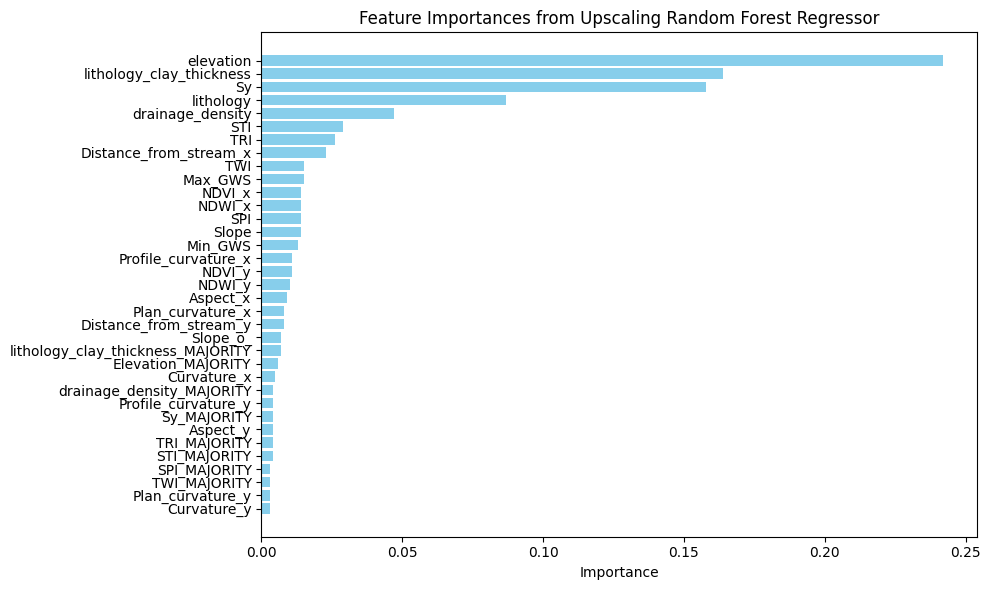

In [69]:

# Display the feature importances
print(importance_df)

# Optionally, plot the feature importances
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances from Upscaling Random Forest Regressor')
plt.gca().invert_yaxis()  # To display the most important features at the top
plt.savefig('Upscaling_model_feature_importance.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()


In [70]:
loaded_model

RandomForestRegressor(random_state=42, verbose=1)

In [71]:
y_pred_all=loaded_model.predict(X_all)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   24.2s


In [72]:
data['Upscaled min']=y_pred_all[:,0]

In [73]:
data['Upscaled max']=y_pred_all[:,1]